# Problem 1.1: Bank Marketing Data
Aaron Bell

## -1) Import core packages

In [1]:
# for displaying plots in a notebook
%matplotlib inline 

import numpy as np # simply array and mathematical operations
import pandas as pd # R-like handling with dataframes, etc.
import seaborn as sb # for making your statistical plots look pretty
import matplotlib.pyplot as plt

# 0) Data loading
pandas allows for easy reading-in of CSV and other files. 
We'll load the data into a pandas dataframe (analagous to R dataframes), then take a look at how it's stuctured.

IMPORTANT: 'read_csv' sometimes gets confused if the file is delimited in a weird way. In this case, the columns are separated by semi-colon rather than comma, se we have to set 'sep = ";"'. Otherwise all the data go to one column.

We also know from the instructions (copied at the end of this notebook) that the target label is column 'y'. This corresponds to is whether customers said "yes" or "no" to a term deposit.

In [2]:
data_original   = pd.read_csv('data/raw/bank-additional/bank-additional-full.csv', sep = ";")
data = data_original.copy()

labels = data["y"].copy()
data   = data.drop("y",axis=1)

data.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,261,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,149,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0
2,37,services,married,high.school,no,yes,no,telephone,may,mon,226,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,151,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0
4,56,services,married,high.school,no,no,yes,telephone,may,mon,307,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0


# 1) Data splitting

To make sure we're testing our process as objectively, we don't want the data we use to fit the model ("training" data) to be mixed with the data used for the final performance test ("testing" data). 

First we'll try a simple 70/30, training/testing spit, randomly selecting data points for each set.

We won't take any looks at the the data until it's split, so that the test can be as independent as possible from our analysis strategy. 

In [3]:
from sklearn.model_selection import train_test_split

train, test, train_labels, test_labels = train_test_split(data, labels, test_size=0.33, random_state=1337)

Let's see what the data types are, and how many entries we have after the split.

In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 27595 entries, 14401 to 3223
Data columns (total 20 columns):
age               27595 non-null int64
job               27595 non-null object
marital           27595 non-null object
education         27595 non-null object
default           27595 non-null object
housing           27595 non-null object
loan              27595 non-null object
contact           27595 non-null object
month             27595 non-null object
day_of_week       27595 non-null object
duration          27595 non-null int64
campaign          27595 non-null int64
pdays             27595 non-null int64
previous          27595 non-null int64
poutcome          27595 non-null object
emp.var.rate      27595 non-null float64
cons.price.idx    27595 non-null float64
cons.conf.idx     27595 non-null float64
euribor3m         27595 non-null float64
nr.employed       27595 non-null float64
dtypes: float64(5), int64(5), object(10)
memory usage: 4.4+ MB


So we have ourselves a mixed-bag of data here. We won't be able to just charge-forward with either a categorical or quantitative approach... 

Now let's see a sample of the data table itself.

In [5]:
train.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
14401,38,blue-collar,single,basic.9y,unknown,yes,no,cellular,jul,mon,72,3,999,0,nonexistent,1.4,93.918,-42.7,4.962,5228.1
35284,39,admin.,married,university.degree,no,yes,no,cellular,may,fri,364,2,999,0,nonexistent,-1.8,92.893,-46.2,1.250,5099.1
1225,36,blue-collar,married,basic.6y,unknown,no,no,telephone,may,thu,166,1,999,0,nonexistent,1.1,93.994,-36.4,4.855,5191.0
8289,53,self-employed,married,university.degree,no,yes,no,telephone,jun,tue,119,4,999,0,nonexistent,1.4,94.465,-41.8,4.864,5228.1
31412,32,technician,single,professional.course,no,yes,no,cellular,may,wed,97,2,999,0,nonexistent,-1.8,92.893,-46.2,1.334,5099.1


Some columns show missing or N/A values, like 'unknown' in 'default', and 'nonexistent' in 'poutcome'. We may not necessarily keep all the columns, but we have to choose a strategy now for handling rows ("participants") that have missing data values.

For this project, let's take a conservative approach- remove entire rows that have 'unknown' values. This is to avoid treating 'unknown' as carrying the same degree of meaning as the defined categories. We don't know why this data are unknown, and we can't assume that two people who have 'unknown' education values have anything in common. 

Value '999' for 'pdays' also carries no quantitative meaning. But at the same time, if we remove all of these rows, then we're removing all the data where the participant was being called for the first-time. We'll leave these rows for now, but consider removing the 'pdays' column later.

In [6]:
train_labels.head()

14401    no
35284    no
1225     no
8289     no
31412    no
Name: y, dtype: object

In [7]:
def dropMissingData(data, labels, missing_val, missing_val_cols, labels_colname = "y"):
    
    data_temp = data.join(labels)
    #print data_temp.head()
    
    for missing_val_col in missing_val_cols:
        
        data_temp = data_temp[ data[missing_val_col]!=missing_val  ]

    labels_temp = data_temp[labels_colname]
    data_temp   = data_temp.drop(labels_colname, axis=1)
    
    return data_temp, labels_temp

train, train_labels = dropMissingData(train,
                                      train_labels, 
                                      missing_val="unknown", 
                                      missing_val_cols = ["education","marital","default","job"],
                                      labels_colname = "y")
train_labels.head()

/work1/users/aaronb/Softbrary/Anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


35284    no
8289     no
31412    no
22884    no
25811    no
Name: y, dtype: object

In [8]:
len(train.default[train.default=="unknown"])

0

# 3) Feature Selection

We're given 21 features, which is tempting to just throw at a black-box and see what comes out.
But let's show some patience, and pre-analyze which features are the most useful, which are redundant and uninformative.

In to the instructions, we're told that "duration" had best be omitted:  
```...the duration is not known before a call is performed. Also, after the end of the call y is obviously known. Thus, this input should only be included for benchmark purposes and should be discarded if the intention is to have a realistic predictive model. ``` 

Which makes sense. If you are looking at a spread-sheet of client data, you have no idea how long a phone call in their future is going to last. If the call duration was being controlled somehow by the telemarketers, we could test if keeping participants on the phone longer related to more "yes" answers. But we don't know that in this case. We just assume that 'duration' means the after-the-fact length of the call, including time it takes for customers to ask questions and confirm their answers, and that the telemarketers were not artifically controlling the call length. 

So let's drop it.

In [9]:
train = train.drop("duration", axis=1)

## 3.2) Isolate the quantitative columns

Some data are given to us as numbers. Others are string labels, without an obvious way to rank them.

The quantitative data are either integer ('int64') or floats ('float64'). The qualitative, string data are given as object data type, indicatd by 'O'. We'll call the qualitative ones 'nom_cols', so we don't confuse it with 'quant_cols'.

In [10]:
train.dtypes.values

array([dtype('int64'), dtype('O'), dtype('O'), dtype('O'), dtype('O'),
       dtype('O'), dtype('O'), dtype('O'), dtype('O'), dtype('O'),
       dtype('int64'), dtype('int64'), dtype('int64'), dtype('O'),
       dtype('float64'), dtype('float64'), dtype('float64'),
       dtype('float64'), dtype('float64')], dtype=object)

In [11]:
quant_cols  = train.columns.values[(train.dtypes =='int64') | (train.dtypes =='float64')]
quant_cols

array(['age', 'campaign', 'pdays', 'previous', 'emp.var.rate',
       'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed'], dtype=object)

## 3.3) Variance test the quantitative features

Asking "How informative is this column?" is like asking "How much does this column tell us about how data points vary from one another?". 

For the quantitative data, there's a straight-forward way to test this--- look at the variance. To do this properly, we have to put the data into the same scale. Depending on the modeling method we try, this might have to do this anyways (i.e. for neural networks).


We'll first set a threshold for the variance, let's say 0.2, and then exclude columns that don't meet this threshold. A good example from scikit learn's documentations shows a variance filter of 0.8, so let's use that for the moment. (Important to keep in mind that the y-columns itself shows low variance, with the vast majority being "No"s.)

In [12]:
n_yes = len(train_labels[train_labels=="yes"])
n_no  = len(train_labels[train_labels=="no"])
yes_no_ratio =  (n_yes/(n_yes+n_no))*100
print "Number of 'Yes' responses: {}".format(n_yes)
print "Number of 'No' responses: {}".format(n_no)

Number of 'Yes' responses: 2672
Number of 'No' responses: 18325


In [13]:
from sklearn.feature_selection import VarianceThreshold
from sklearn.preprocessing import StandardScaler
sel = VarianceThreshold(threshold=0.2)
mmscale = StandardScaler(with_std=False)
train_scaled = pd.DataFrame(
    mmscale.fit_transform( train[quant_cols] ), 
    columns= train[quant_cols].columns)

sel.fit_transform(train_scaled)
 
print sel.variances_

print sel.get_support()

train_scaled.head()

[  1.05763219e+02   7.23983410e+00   4.03346286e+04   2.70406619e-01
   2.60177040e+00   3.42982542e-01   2.29885910e+01   3.16484341e+00
   5.66210077e+03]
[ True  True  True  True  True  True  True  True  True]


,age,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
0,-0.01786,-0.522313,42.426204,-0.193266,-1.725975,-0.630254,-5.602115,-2.206138,-61.49658
1,13.98214,1.477687,42.426204,-0.193266,1.474025,0.941746,-1.202115,1.407862,67.50342
2,-7.01786,-0.522313,42.426204,-0.193266,-1.725975,-0.630254,-5.602115,-2.122138,-61.49658
3,-9.01786,0.477687,42.426204,-0.193266,1.474025,-0.079254,4.497885,1.508862,67.50342
4,-1.01786,-1.522313,42.426204,-0.193266,-0.025975,-0.323254,-1.402115,0.663862,35.20342


Interestingly all of our quanttative features pass the variance test. Although two of them just barely, 'pdays' and 'previous'. These two must be correlated, since you can only have a previous outcome recorded if you have a valid value for pdays. In any case, the numeric value of "999" for pdays has no meaning.

In [14]:
train = train.drop(['pdays','poutcome','previous','campaign'], axis=1)
quant_cols  = train.columns.values[(train.dtypes =='int64') | (train.dtypes =='float64')]
nom_cols = train.columns.values[train.dtypes == 'O']

# 3.4) Check for redundance in the quantitative features

Let's take the quantitative data aside for a minute, and see if any of the columns are storngly related or redundant. 

One way of doing this is through a simple correlation test. Pandas gives us a quick and convenient way to get a correlation coefficient (pearson, spearman) for all of the features in our dataset, vs. each other. Or something like a normalized covariance matrix.

I prefer to use Spearman as the default corr. test, since it doesn't assume we're looking at linear trends, and is less sensitive to outliers.

In [15]:
train_corrmat = train[quant_cols].corr(method="spearman")

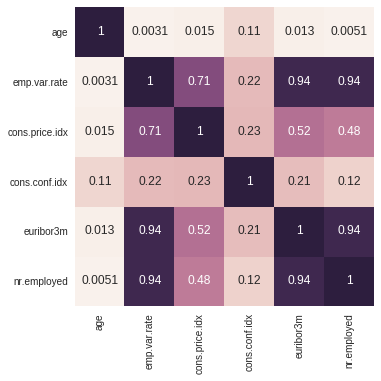

In [16]:
sb.heatmap(train_corrmat, annot=True,cbar=False, square=True)

Here we can see something interesting: 
'euribor3m', 'nr.employed' and 'emp.var.rate' are strongly correlated.

Per the data guide, these are all different ways of diagnosing the socio-economic environment, at the time of the call. They don't have anything to do with the participants themselves.

Which one do we drop? While they are all "quaterly" average measures, only one of them gives a daily running average, and that's the 'euribor' (which affects the rate of return on term-deposits?). Perhaps this daily variation will tell us more about the specific conditions for each caller. This choice is arbitrary choice, but for now I want to simplify the dataset while developing a strategy.

Also it should come as no surprise that a participants age has nothing to do with the economic conditions on the day of the call.

In [17]:
redundant_cols = ["nr.employed", "emp.var.rate"]

In [18]:
train = train.drop(redundant_cols, axis=1)
quant_cols  = train.columns.values[(train.dtypes =='int64') | (train.dtypes =='float64')]

# 4) Pre-analysis: Categorical data

Now let's take a look at some of our categorical data. For starters, just look at t he attributes that are intrinsic attribut.
es of the participant- not the phone they used, not what the economic weather was like. This leaves education, job, and age. Well, marital status, housing, financial status can arguably be "intrinsic", but let's start with the basics. 

Perhaps we can agree that age would be the most objective, quantitatve attribute of a caller, among the data we have. Let's start there:

0
0


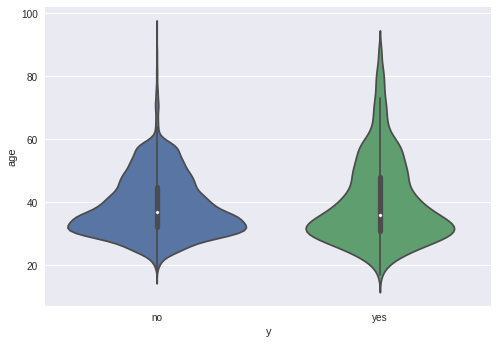

In [19]:
# Age distributions of yesses and nos:
sb.violinplot(x=train_labels, y=train.age)
print len(train_labels[(train_labels=="yes") & (train.age > 60)])/len(train_labels[train_labels=="yes"])
       
print len(train_labels[(train_labels=="no") & (train.age > 60)])/len(train_labels[train_labels=="no"])

Without getting to an objective measure here, it as at least visually obvious that the yesses (1s) have a thicker tail out past the retirement ages (though we can't assume yet that all these people are "retired" per-se).

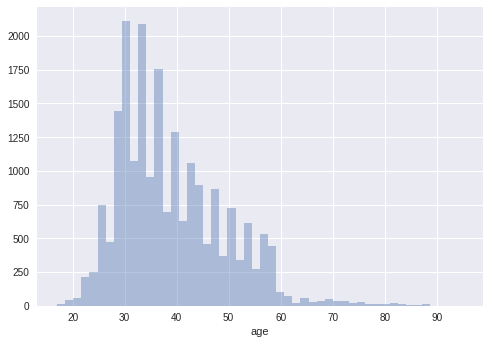

In [20]:
sb.distplot(train.age, kde=False)

When we look at the distribution of ages, we see that the "violin" plots from before can be a bit misleading.

While they seem to tell us that there is an overall trend with age,the age distribution above below tells us that there are very few participants over age 60. So while it may be accurate to say that, within those over 60, there is a trend to say yes- there is likely not a significant trend in this data for those who say yes to be over 60. 

We can't rule out a samping bias, but we do have to be careful about density plots. The reason for the confusion is that, for each side of the violin plots, the area is normalized to that category. So it falseley represents the groups is being roughly equal.

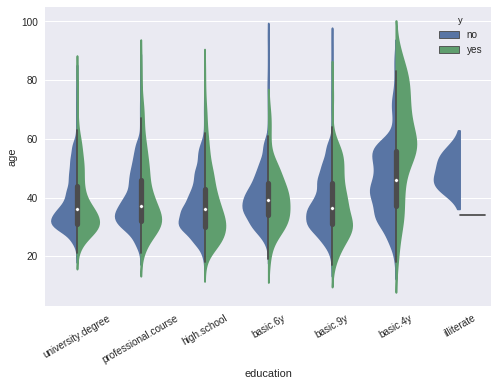

In [21]:
# Education-age demographics
g = sb.violinplot(x=train.education, y=train.age, hue=train_labels, split=True)
tick_labels = g.set_xticklabels(g.get_xticklabels(),rotation=30)

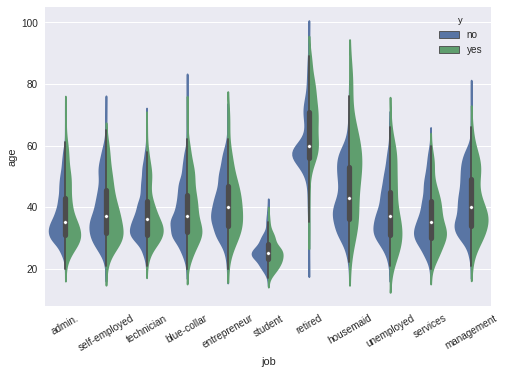

In [22]:
# Job-age demographic
g = sb.violinplot(x=train.job, y=train.age, hue=train_labels, split=True)
tick_labels = g.set_xticklabels(g.get_xticklabels(),rotation=30)

The "retired" category is interesting. Maybe we would not be wrong in assuming our retirement-aged yessers are in-fact retired. But then again, we see an extended advanced-age-tail with the "housemaid" category as well.

# 5) Process the categorical data

A few of our data columns lend themselves to straightforward numerical relabeling. For example, January -> 1, Monday -> 2. Not to say that these have an intrinsic quantitative meaning, but it makes sense to use the conventional integer labels rather than arbitrary ones, to maximixe readability.

Some easy things we can convert are month and day of the week to 1-12 and 1-7

In [23]:
def relabelData(input_labels, input_frame, column):
    
    for i in range(0,len(input_frame[column])):
        for j in range(0,len(input_labels)):
            if input_frame[column].values[i] == input_labels[j]:
                input_frame[column].values[i] = j
                
    return input_frame[column]
                


In [24]:
#%%timeit
months = ['jan','feb','mar','apr','may','jun','jul','aug','sep','oct','nov','dec']  
train.month = relabelData(months, train, "month")

# Add one so that the month numbers correspond to conventional dates - Jan = 1, etc.
train.month+=1

In [25]:
train.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,cons.price.idx,cons.conf.idx,euribor3m
35284,39,admin.,married,university.degree,no,yes,no,cellular,5,fri,92.893,-46.2,1.250
8289,53,self-employed,married,university.degree,no,yes,no,telephone,6,tue,94.465,-41.8,4.864
31412,32,technician,single,professional.course,no,yes,no,cellular,5,wed,92.893,-46.2,1.334
22884,30,technician,divorced,high.school,no,no,no,cellular,8,mon,93.444,-36.1,4.965
25811,38,blue-collar,married,basic.6y,no,yes,no,cellular,11,wed,93.200,-42.0,4.120


Re-label days of the week

In [26]:
#%%timeit 
weekdays = ['sun','mon','tue','wed','thu','fri','sat']  
train.day_of_week = relabelData(weekdays, train,"day_of_week")

train.day_of_week+=1

train.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,cons.price.idx,cons.conf.idx,euribor3m
35284,39,admin.,married,university.degree,no,yes,no,cellular,5,6,92.893,-46.2,1.250
8289,53,self-employed,married,university.degree,no,yes,no,telephone,6,3,94.465,-41.8,4.864
31412,32,technician,single,professional.course,no,yes,no,cellular,5,4,92.893,-46.2,1.334
22884,30,technician,divorced,high.school,no,no,no,cellular,8,2,93.444,-36.1,4.965
25811,38,blue-collar,married,basic.6y,no,yes,no,cellular,11,4,93.200,-42.0,4.120


So those were fairly straightforward, since months and days of the week have an obvious order to them. 

But what do we do with things like "job" and "education"? We'll have to be a bit more arbitrary about it, if we want to do any numerical analysis or apply vectorized routines to speed things up. At least Education has a kind of chronology to it- high-school before university, and so on. 

If we enforce an order on something like "job" though, we're may be implicitly making assumptions about its correlation with other data. 

The remaining columns don't have an obvious way to numberize them. We could convert education to years of education, but then what do we do with labels like 'illiterate'? We have to be careful though, not to transform the columns that we already dealt with.

In [27]:
encode_cols = nom_cols[(nom_cols!="month") & (nom_cols!="day_of_week")].copy()
encode_cols

array(['job', 'marital', 'education', 'default', 'housing', 'loan',
       'contact'], dtype=object)

In [28]:
from sklearn import preprocessing
nom_encoder = preprocessing.LabelEncoder()
train[encode_cols].apply(nom_encoder.fit_transform).head()

,job,marital,education,default,housing,loan,contact
35284,0,1,6,0,2,0,0
8289,6,1,6,0,2,0,1
31412,9,2,5,0,2,0,0
22884,9,0,3,0,0,0,0
25811,1,1,1,0,2,0,0


In [29]:
train[encode_cols] = train[encode_cols].apply(nom_encoder.fit_transform)
train.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,cons.price.idx,cons.conf.idx,euribor3m
35284,39,0,1,6,0,2,0,0,5,6,92.893,-46.2,1.250
8289,53,6,1,6,0,2,0,1,6,3,94.465,-41.8,4.864
31412,32,9,2,5,0,2,0,0,5,4,92.893,-46.2,1.334
22884,30,9,0,3,0,0,0,0,8,2,93.444,-36.1,4.965
25811,38,1,1,1,0,2,0,0,11,4,93.200,-42.0,4.120


In [30]:
labels_encoder = preprocessing.LabelEncoder()

print train_labels.head()
#labels_encoder.fit_transform(train_labels)

train_labels = pd.DataFrame(labels_encoder.fit_transform(train_labels), columns=["y"])

train_labels.head()

35284    no
8289     no
31412    no
22884    no
25811    no
Name: y, dtype: object


,y
0,0
1,0
2,0
3,0
4,0


# 6.1) Modelling experiments: Decision tree

While I'm not an expert in decision trees-- I have only read about them -- among the methods I find for mixed-data type machine learning, I prefer it because of the relative transparency. A decision tree produces a graoh of its steps which we can easily visualize. MCA, while seemingly straightforward if we call it "PCA for categorical data", is more mathematically complex to describe. Neural nets are infamously opaque.

What follows is largely based on scikit learn examples, either from their online documentation or 
http://scikit-learn.org/stable/modules/tree.html

In [31]:
from sklearn import tree

model = tree.DecisionTreeClassifier(random_state=1337) # We are using classifier rather than regressor, because or goal is to "classify" participants into "yes" and "no" categories.

model = model.fit(train,train_labels)

In [32]:
def preProcess(data, labels, drop_cols, missing_val, missing_val_cols, labels_colname = "y"):
    
    from sklearn.preprocessing import LabelEncoder
    
    data = data.drop(drop_cols, axis=1)
    
    data, labels = dropMissingData(data, labels, missing_val, missing_val_cols, labels_colname = "y")
    
    nom_cols = data.columns.values[data.dtypes == 'O']    
    
    nom_encoder = LabelEncoder()

    data[nom_cols] = data[nom_cols].apply(nom_encoder.fit_transform)
    
    labels_encoder = LabelEncoder()
    
    labels = pd.DataFrame(labels_encoder.fit_transform(labels), columns=["y"])
    
    #print data.head()
    
    return data, labels


drop_cols         = ['nr.employed', 
                     'emp.var.rate',
                     'pdays',
                     'poutcome',
                     'previous',
                     'campaign', 
                     'duration']

missing_val       = 'unknown'

missing_val_cols  = ['education','marital','job','default']
    
test, test_labels = preProcess(test, test_labels, drop_cols, missing_val, missing_val_cols)


/work1/users/aaronb/Softbrary/Anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


Just for diagnostics, let's see how the model fits the training data. This is not a valid way to say if our model will work in reality. It just helps us see if something has gone terrible wrong so far. What we expect at this point is that the model works well for the training data. If it can't even fit data it has already seen however, that means we have other issues to resolve first.

First, apply the model we just trained to the training data to get the predicted labels.

In [33]:
train_predicted_labels = model.predict(train)

Next we get a few performance metrics for the predictions.

In [34]:
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, roc_auc_score, f1_score


def reportPerformance(test_labels, predict_labels):
    
    print "Accuracy score: {}".format(  round( 
        accuracy_score(test_labels, predict_labels)
        ,3))

    print "Precision score: {}".format( round( 
        precision_score(test_labels, predict_labels)
        ,3))

    print "Recall score: {}".format(    round( 
        recall_score(test_labels, predict_labels)
        ,3))

    print "ROC score: {}".format(   round( 
        roc_auc_score(test_labels, predict_labels)
        ,3))
    
    print "f1 score: {}".format(   round( 
        f1_score(test_labels, predict_labels, pos_label=1)
        ,3))
    
reportPerformance(train_labels, train_predicted_labels)

Accuracy score: 0.986
Precision score: 0.993
Recall score: 0.893
ROC score: 0.946
f1 score: 0.94


The model performs suspiciously well on the training data...but of course it performs well on data it's already seen. The very high accuracy rate smells a bit of over fitting. Next we'll see how it does with the test data, which it's never encountered.

To test our fitted model, we have to apply all of the above pre-processing steps to the test data as well. Let's bundle those into a function that we can use for later exeriments.

We'll also want to have a quick way to check various performanc measure of the model: Accuracy, precision, and recall. To be honest, accuracy is not really helpful in this case, since the main goal is finding the minority of cases where the result was "yes". 

A model that always predicts "no" would give us a misleadingly good accuracy.

A model that always predicts "yes" (looking under every stone) would give us a perfect recall score, but in practice would waste hours of telemarketing time and resources.

A 50/50 coin-flip model would give is a recall of about 50%. Same for accuracy. So we have to be careful to compare the scores together, and remember that it's entirely possible for a complex model to be less effective than asking your cat for advice.

It seems our model doesn't generalize very well to data it hasn't seen yet. Perhaps the tree is being over-fit to the data?

The recall rate of 0.333 says that we're recovering 1/3 of would-be depositors. Worse than flipping a coin.



# 6.2) Modelling experiments: Random forests


Next we'll try an extension of the decision tree model, called "random forests". This is a way of preventing overfitting to the data, but constructing many different decision trees, with different subsets of the provided features and datasets.

It's a bit more difficult to deal with though, since we have to choose the number of different trees generated in the procedure. The following cell fits the model for different values of 'n_estimators', the number of decision trees, and check which performs best via the OOB error rate.

/work1/users/aaronb/Softbrary/Anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


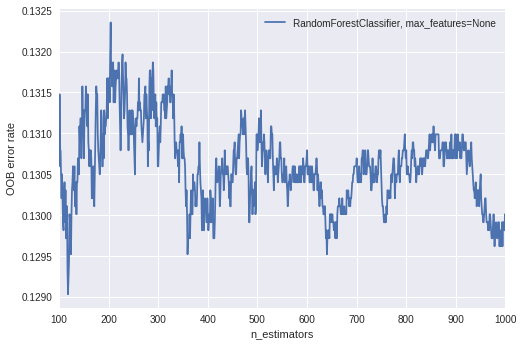

In [35]:
#Following example from stack exchange, for optimizing the number of estimators in the random forest

import matplotlib.pyplot as plt

from collections import OrderedDict

from sklearn.ensemble import RandomForestClassifier


def findMinOOB(test, test_labels, min_estimators = 10, max_estimators = 1000, random_state = 1337):
    
    ensemble_clfs = [ ("RandomForestClassifier, max_features=None",RandomForestClassifier(random_state=random_state,warm_start=True, max_features=None, oob_score=True,))]


    error_rate = OrderedDict((label, []) for label, _ in ensemble_clfs)

    for label, clf in ensemble_clfs:
        for i in range(min_estimators, max_estimators + 1):
            clf.set_params(n_estimators=i)
            clf.fit(test, test_labels)
            oob_error = 1 - clf.oob_score_
            error_rate[label].append((i, oob_error))


    for label, clf_err in error_rate.items():
        xs, ys = zip(*clf_err)
        plt.plot(xs, ys, label=label)

    plt.xlim(min_estimators, max_estimators)
    plt.xlabel("n_estimators")
    plt.ylabel("OOB error rate")
    plt.legend(loc="upper right")
    plt.show()
    
    #print "Min. OOB of {} found at N_estimators = {}".format()
    
findMinOOB(test, test_labels, min_estimators = 100, max_estimators = 1000, random_state = 1337)

While we see a steady decrease past 900, it's interesting that the minimum occurs at about 110. I'll prefer the more consistently lower error rate ~1000 for the moment. In a production environment though, it would probably be better to more thoroughly balance 'n_estimators' with the error rate, so that we don't waste computation time while re-testing.

In [36]:
# from sklearn.model_selection import GridSearchCV

# def getRandomForestBestParams(param_grid, data, labels, scoring = 'f1', random_state=1337):
    
#     estimator = RandomForestClassifier(random_state=random_state)

#     gs = GridSearchCV(estimator, 
#                  param_grid,
#                  scoring = 'f1')

#     gs = gs.fit(train, train_labels.y)

#     print "Best Parameters: {}".format(gs.best_params_)

#     print "Best Score: {}".format(gs.best_score_)
    
#     return gs

# param_grid = [
#       {'n_estimators':range(100,1000,25),'max_features': range(2,(len(data.columns)-1))},
#      ]

# gs = getRandomForestBestParams(param_grid, train, train_labels)

Now we'll feed the best parameters into the model.

In [38]:
def predictWithRandomForest(train, train_labels, test, test_labels, n_estimators,  random_state=1337):

    model_forest = RandomForestClassifier(n_estimators=n_estimators,
                                          random_state=random_state, 
                                           oob_score=True) # We are using classifier rather than regressor, because or goal is to "classify" participants into "yes" and "no" categories.

    model_forest = model_forest.fit(train, train_labels)


    predict_labels = model_forest.predict(test)

    reportPerformance(test_labels, predict_labels)
    
    return model_forest
    
model_forest = predictWithRandomForest(train, train_labels, test, test_labels, n_estimators=1000, random_state=1337)

/work1/users/aaronb/Softbrary/Anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:7: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  import sys


Accuracy score: 0.872
Precision score: 0.473
Recall score: 0.223
ROC score: 0.594
f1 score: 0.303


# 6.2 Modeling experiments: Undersampling

The random forest approach doesn't really seem to help us out here, relative to the simple decision tree approach.

Another issue is that our number of "no"s is way higher than the number of "yesses". More than simply a classification problem, this is really a recall problem. We're hunting for needles in the haystack, rather than sorting red fish from blue fish.'

Next we'll play with the method of data splitting, rather than the model itself. We'll try and weight our training data more towards the "Yes" case, by inflating the number of yesses to match the number of nos. For this attempt, we'll arbirarily force the yes-to-no ratio to 0.5.

In [60]:
print len(labels[labels=="no"])
print len(labels[labels=="yes"])
2*5289/3

36548
4640


3526

So let's take 2/3 of 5289 as the test set. But we want to try and use equal proportions of yes and no cases, so let's also take (2/3)*5289 of samples for the no cases.

In [61]:
size = labels.size

split_ratio = 2/3 #proportion of data taken as training

size_yes    = len(labels[labels=="yes"])
size_no     = len(labels[labels=="no"])


print "Number of 'No' Cases: {}/{}".format(size_no,size)
print "Number of 'Yes' Cases: {}/{}".format(size_yes,size)

#print "Number of 'No' Training Cases " 
train_size_yes = (size_yes*2)//3 
train_size_no  = train_size_yes

test_size_yes = size_yes - train_size_yes
test_size_no  = size_no  - train_size_no

train_yes, test_yes, train_labels_yes, test_labels_yes   = train_test_split(data[labels=="yes"], labels[labels=="yes"], test_size=test_size_yes, random_state=1337)
train_no , test_no,  train_labels_no,  test_labels_no    = train_test_split(data[labels=="no"],  labels[labels=="no"],  test_size=test_size_no, random_state=1337)

Number of 'No' Cases: 36548/41188
Number of 'Yes' Cases: 4640/41188


In [62]:
data.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,261,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,149,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0
2,37,services,married,high.school,no,yes,no,telephone,may,mon,226,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,151,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0
4,56,services,married,high.school,no,no,yes,telephone,may,mon,307,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0


In [63]:
train_yes.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
8866,28,technician,single,professional.course,no,no,no,telephone,jun,thu,508,2,999,0,nonexistent,1.4,94.465,-41.8,4.866,5228.1
20238,34,admin.,married,university.degree,no,no,no,cellular,aug,mon,1238,1,999,0,nonexistent,1.4,93.444,-36.1,4.965,5228.1
30253,48,technician,divorced,high.school,no,yes,no,cellular,apr,thu,400,1,999,1,failure,-1.8,93.075,-47.1,1.365,5099.1
30441,39,admin.,married,high.school,no,yes,no,cellular,may,mon,303,3,999,0,nonexistent,-1.8,92.893,-46.2,1.354,5099.1
31011,45,blue-collar,married,basic.9y,no,yes,no,cellular,may,tue,672,2,999,0,nonexistent,-1.8,92.893,-46.2,1.344,5099.1


### Shuffle the data

In [64]:
from sklearn.utils import shuffle

def shuffleTogether(data_yes, data_no, labels_yes, labels_no, random_state = 1337, labels_col = "y"):
    
    data   = data_yes.append(data_no)
    labels = labels_yes.append(labels_no)
    
    data = data.join(labels)
    
    data = shuffle(data, random_state = random_state)
    
    labels = data[labels_col]
    
    data   = data.drop(labels_col, axis=1)
    
    return data, labels

train_under, train_labels_under = shuffleTogether(train_yes, train_no, train_labels_yes, train_labels_no)
test_under, test_labels_under   = shuffleTogether(test_yes,  test_no, test_labels_yes, test_labels_no)

In [65]:
train_under.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
8522,31,blue-collar,married,basic.6y,no,yes,no,telephone,jun,wed,406,2,999,0,nonexistent,1.4,94.465,-41.8,4.864,5228.1
19967,50,blue-collar,married,basic.6y,no,no,no,cellular,aug,fri,733,3,999,0,nonexistent,1.4,93.444,-36.1,4.966,5228.1
39495,77,retired,married,high.school,no,yes,no,cellular,apr,thu,165,7,999,0,nonexistent,-1.8,93.749,-34.6,0.644,5008.7
37878,53,admin.,married,university.degree,no,yes,no,cellular,aug,mon,267,1,999,1,failure,-2.9,92.201,-31.4,0.821,5076.2
29148,53,admin.,married,basic.6y,no,yes,no,cellular,apr,fri,100,1,999,0,nonexistent,-1.8,93.075,-47.1,1.405,5099.1


### Apply same pre-processing as before

In [66]:
train_under, train_labels_under  = preProcess(train_under, train_labels_under, drop_cols, missing_val, missing_val_cols)
test_under,  test_labels_under   = preProcess(test_under,  test_labels_under,  drop_cols, missing_val, missing_val_cols)

/work1/users/aaronb/Softbrary/Anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


In [ ]:
findMinOOB(train_under, train_labels_under, min_estimators = 100, max_estimators = 1500, random_state = 1337)

In [67]:
from sklearn.ensemble import RandomForestClassifier

model_forest = RandomForestClassifier(n_estimators=500,
                                      random_state=1337, 
                                      oob_score=True) # We are using classifier rather than regressor, because or goal is to "classify" participants into "yes" and "no" categories.

model_forest = model_forest.fit(train_under, train_labels_under)


predict_labels_under = model_forest.predict(test_under)

reportPerformance(test_labels_under, predict_labels_under)

/work1/users/aaronb/Softbrary/Anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:7: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  import sys


Accuracy score: 0.735
Precision score: 0.125
Recall score: 0.706
ROC score: 0.721
f1 score: 0.212


In [ ]:
model_forest.feature_importance

While we get the best recall rate among any of the methods here, our method is still very crude. It tends to recognize the "Yes" customers, sure, but it also gives us a lot of false-positives.

# Conclusion:

I have tried several modeling approaches to predict the outcome of a telemarketing campagin. Of all the approaches, the most effective 

I've avoided making a model that predicts based on the length of the calls, as this seems a bit circular. This differs from many examples I have found online, which found that call duration is a good predictor. My hope was to try and explore a bit deeper than this, and predict based on more independent data.

The bottom line is that the results are not very positive. But why? Well, if I were to take more time to get to the bottom of it, I would explore more rigorous approaches to tuning the models. The other interesting thing, which appears in the article connected to this data, is that they made a reasonable prediction using neural networks. This is something I would like to try if I had more time, but so far I avoided it because I do not feel neural networks are a good "default" approach, unless the task is something like image classification. The reason is that it is hard to visualize what a NN has actually done, at the end, when we are dealing with a mix of quantitative and qualitative data. Especially socio economic data... but perhaps I'm being too pessimistic, and it's worth a try to see how NNs compare to random forest approaches, SVMs,  etc.

The other point is data pre-processing. Although "inflating" the proportion of "Yes" samples in the training data still only resulted in 70% recall, and a lot of false-positives (translating to a lot of wasted time calling "Nos"), it's important to note that this did increase the recall relative to the random-sampling case (training Yes/No proportions equal to that of the full data set.) Interesting, but not shocking: we gave our model more Yes examples, so it tended to guess "Yes" more frequently when it saw the test data. While accuracy of ~75%, and recall of ~70% are better than a coin-flip, this is probably not enough of a trade-off to implement the model in actual callee-selection. Perhaps the undersampling method however could be tuned more for better results.

Based on the simple pre-analysis I did, using violin plots, etc., I realize that there is one data dimension seriously lacking here. That is an objective, quantitative indicator of a customers income, or better yet, disposable income. After all, someone cannot sign up for a term-deposit if they do not have a surplus of cash to deposit. Even just the fact that someone is wealthy is not an indicator of this, since their budget could be strictly balanced. As of now, there is no data that separates the objective "Ability to deposit" from the subjective "Willingness to deposit".

My main reason for suspecting the need for such data, is the relatively high percentage of "Yes" responses for customers over the age of 60, and the same for the "retired" category. While it is speculative, it may be the case that some of these are individuals with lifetime savings, open to wealth-management options. But by the same token, as the advanced age group overlaps with the low-eduation (basic.4yr) group, we could speculate that some of them did not understand the details of the call. It's worth considering, and maybe getting more data, but not nearly strong enough evidence to make a marketing recommendation.

# 6.3***) Modeling experiments:  Playing with MCA

* **This section was added just out of my own curiosity. It is basically me playing with a completely new method I'd just heard about. 
Feel free to skip it on just read the Conclusions section that follows**

Another option, for dealing with categorical labels, is Multiple Correspondance Analysis. This seems to be something of a categorical analog of Principal Component Analysis. What follows is essentially an attempt to apply the steps in the Python MCA tutorial (http://nbviewer.jupyter.org/github/esafak/mca/blob/master/docs/mca-BurgundiesExample.ipynb) to the present dataset. They had originally applied MCA to wine-tasting data.

In [96]:
import mca

In [97]:
np.set_printoptions(formatter={'float': '{: 0.4f}'.format})
pd.set_option('display.precision', 5)
pd.set_option('display.max_columns', 25)

In [95]:
ncols   = len(train[nom_cols].columns)
mca_ind = mca.MCA(train[nom_cols], ncols=ncols, benzecri=False)

print mca.MCA.__doc__


TypeError: No loop matching the specified signature and casting
was found for ufunc svd_n_f

In [98]:
mca_ind.L
mca_ind.expl_var(greenacre=False, N=2)



NameError: name 'mca_ind' is not defined

In [ ]:
data = np.array([mca_ind.L[:2], 
                 mca_ind.expl_var(greenacre=False, N=2) * 100]).T
df = pd.DataFrame(data=data, columns=['cλ','%c'], index=range(1,3))
df

In [ ]:
data = np.array([mca_ind.L[:2], 
                 mca_ind.expl_var(greenacre=False, N=2) * 100]).T
df = pd.DataFrame(data=data, columns=['cλ','%c'], index=range(1,3))
df

In [ ]:
fs, cos, cont = 'Factor score','Squared cosines', 'Contributions x 1000'
table3 = pd.DataFrame(columns=train[nom_cols].index, index=pd.MultiIndex
                      .from_product([[fs, cos, cont], range(1, 3)]))

table3.loc[fs,    :] = mca_ind.fs_r(N=2).T
table3.loc[cos,   :] = mca_ind.cos_r(N=2).T
table3.loc[cont,  :] = mca_ind.cont_r(N=2).T * 1000
#table3.loc[fs, 'W?'] = mca_ben.fs_r_sup(pd.DataFrame([i_sup]), N=2)[0]

np.round(table3.astype(float), 2)

In [ ]:
table4 = pd.DataFrame(columns=train[nom_cols].columns, index=pd.MultiIndex
                      .from_product([[fs, cos, cont], range(1, 3)]))
table4.loc[fs,  :] = mca_ind.fs_c(N=2).T
table4.loc[cos, :] = mca_ind.cos_c(N=2).T
table4.loc[cont,:] = mca_ind.cont_c(N=2).T * 1000


np.round(table4.astype(float), 2)

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt

points = table3.loc[fs].values
labels = table3.columns.values

plt.figure()
#plt.margins(0.1)
plt.axhline(0, color='gray')
plt.axvline(0, color='gray')
plt.xlabel('Factor 1')
plt.ylabel('Factor 2')
plt.scatter(*points, s=120, marker='o', alpha=0.5, linewidths=0)
plt.show()


We can see that MCA pulls out a primary component of our data, explaining 73% of variance. But what we are not seeing is any kind of structure appearing in the data, such that we could easily apply a cluster-based approach like K-means.
Why? Well, maybe it's simply the case that these intrinsic properties of the participants- education job, etc., are not particularly informative when it comes to success rate for the telemarketing campaigns. 

There's one last thing we can try, which is to perform MCA with the labels as an input factor

# 8) Reference

**This is just a copy of the instructions provided on the data archive page**

The webpage for the dataset is located here: https://archive.ics.uci.edu/ml/datasets/bank+marketing

Simple descriptions for each column are given as follows:
Input variables:
# bank client data:
1 - age (numeric)  
2 - job : type of job (categorical: 'admin.','blue-collar','entrepreneur','housemaid','management','retired','self-employed','services','student','technician','unemployed','unknown')  
3 - marital : marital status (categorical: 'divorced','married','single','unknown'; note: 'divorced' means divorced or widowed)  
4 - education (categorical: 'basic.4y','basic.6y','basic.9y','high.school','illiterate','professional.course','university.degree','unknown')  
5 - default: has credit in default? (categorical: 'no','yes','unknown')  
6 - housing: has housing loan? (categorical: 'no','yes','unknown')  
7 - loan: has personal loan? (categorical: 'no','yes','unknown')  
# related with the last contact of the current campaign:
8 - contact: contact communication type (categorical: 'cellular','telephone')   
9 - month: last contact month of year (categorical: 'jan', 'feb', 'mar', ..., 'nov', 'dec')  
10 - day_of_week: last contact day of the week (categorical: 'mon','tue','wed','thu','fri')  
11 - duration: last contact duration, in seconds (numeric). Important note: this attribute highly affects the output target (e.g., if duration=0 then y='no').   
Yet, the duration is not known before a call is performed. Also, after the end of the call y is obviously known. Thus, this input should only be included for benchmark purposes and should be discarded if the intention is to have a realistic predictive model.  
# other attributes:
12 - campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)  
13 - pdays: number of days that passed by after the client was last contacted from a previous campaign (numeric; 999 means client was not previously contacted)  
14 - previous: number of contacts performed before this campaign and for this client (numeric)  
15 - poutcome: outcome of the previous marketing campaign (categorical: 'failure','nonexistent','success')  
# social and economic context attributes
16 - emp.var.rate: employment variation rate - quarterly indicator (numeric)  
17 - cons.price.idx: consumer price index - monthly indicator (numeric)   
18 - cons.conf.idx: consumer confidence index - monthly indicator (numeric)   
19 - euribor3m: euribor 3 month rate - daily indicator (numeric)  
20 - nr.employed: number of employees - quarterly indicator (numeric)  
  
Output variable (desired target):  
21 - y - has the client subscribed a term deposit? (binary: 'yes','no')  